<a href="https://colab.research.google.com/github/PCR-git/Repo1/blob/master/271B_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAE 271B - Final Project
## Missile State Estimation using a Continuous-Time Kalman Filter
### Peter Racioppo

## Initializations

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Time constants
t0 = 0 # Start time
tf = 10 # End time
tau = 2 # Correlation time
dt = 0.01 # Time step (in diff. eq. solver)
length = int(tf/dt) # Number of steps in time interval
tvec = np.linspace(0,length,length)/(length/tf)-tf # Vector of time steps

# Model constants
Vc = 300 # Velocity
R1 = 15*10**-6 # Scintillation noise const. 1
R2 = 1.67*10**-3 # Scintillation noise const. 2
ap = 0 # Missile Acceleration
Ev = 0 # Expectation of the velocity
Ev2 = 200**2 # Expectation of the squared velocity
Ea = 0 # Expectation of the target acceleration
Ea2 = 100**2 # Expectation of the squared target acceleration
En = 0 # Expectation of the scintillation noise
L = 0.25 # The rate lambda in Poisson probability distribution
mode = 0 # Set to 0 for Gauss-Markov or 1 for Random Telegraph

# State space matrices
F = np.array([[0, 1, 0],[0, 0, -1],[0, 0, -1/tau]]) # State Matrix
B = np.array([[0, 1, 0]]) # Input matrix
B = B.reshape(-1,1) # Reshape to column vector
G = np.array([0, 0, 1]) # Forcing matrix
G = G.reshape(-1,1) # Reshape to column vector
# Process noise spectral density
W = np.array([[0, 0, 0],[0, 0, 0],[0, 0, Ea2]])
Hb = np.array([1, 0, 0]) # Output matrix, without constant factor
# Outer product of Hb with itself
Hb2 = np.array([[1, 0, 0],[0, 0, 0],[0, 0, 0]])
# Initial covariance
P0 = np.array([[0, 0, 0],[0, Ev2, 0],[0, 0, Ea2]])

## Dynamic Simulation

In [0]:
# Builds and solves the system's equations of motion
def f_DynamicSim(t0,tf,tau,dt,length,Vc,R1,R2,ap,Ev,Ev2,Ea,Ea2,En,F,B,G,W,Hb2,\
                 P0,L,mode=0):
  # Initializations
  P = np.zeros((length,3,3)) # Covariance matrix at each time step
  X = np.zeros((length,3,1)) # State vector at each time step
  z = np.zeros((length)) # Output vector at each time step
  Xh = np.zeros_like(X) # Estimated state vector at each time step
  Xvar = np.zeros_like(X) # Error variance at each time step
  r = np.zeros((length)) # Innovations process at each time step

  # Kalman Filter gains
  K1 = np.zeros(length)
  K2 = np.zeros_like(K1)
  K3 = np.zeros_like(K1)
  
  # Gaussian initial velocity
  v0 = np.random.normal(loc=Ev,scale=np.sqrt(Ev2))
  X[0,1,0] = v0 # Set initial condition
  
  # Initial acceleration
  if mode == 0:
    # Gauss-Markov Model
    a0 = np.random.normal(loc=Ea,scale=np.sqrt(Ea2))
  elif mode == 1:
    # Random telegraph signal model
    a0 = np.random.choice([-1,1])*np.sqrt(Ea2)
  else:
    np.disp('Error: mode input must be 0 or 1')
  X[0,2,0] = a0 # Set initial condition
  
  # Set initial acceleration
  if mode == 1:
    aT = a0

  tn = 0 # Initialize random telegraph switching time
  
  # Solving the equations of motion
  i = 0 # Iteration counter
  ti = 0 # Time counter
  P[i] = P0 # Covariance initial condition
  # Iterate over time interval
  # Since we start from zero, we should stop a step before tf.
  # Since we compute the (i+1)th outputs at state i, stop one more step early.
  while ti < tf-2*dt:
    # Constants
    denom1 = Vc*R1*(tf-ti) + Vc*R2/(tf-ti)
    Vt = Vc*(tf-ti)
    denom2 = denom1*Vt
    
    # Gaussian scintillation noise
    V = R1 + R2/((tf-ti)**2) # Scintillation noise spectral density
    V /= dt # Divide by time step
    n = np.random.normal(loc=En,scale=np.sqrt(V)) # Scintillation noise
    
    # Forcing function
    if mode == 0:
      # Gauss-Markov model (divide Ea2 by dt)
      wa = np.random.normal(loc=Ea,scale=np.sqrt(Ea2/dt))
    elif mode == 1:
      # Random telegraph signal model
      # Probability of acceleration switching in time interval dt
      prob_switch = 1 - np.exp(-L*dt)
      # Switch sign of acceleration
      aT = aT*np.random.choice([-1, 1], 1, p=[prob_switch, 1-prob_switch])
      wa = 0 # Set forcing function to zero
    else:
      np.disp('Error: mode input must be 0 or 1')
      
    # Covariance derivative at step i
    Pp = np.matmul(F,P[i]) + np.matmul(P[i],F.T) - np.matmul(P[i],\
         np.matmul(Hb2,P[i]))/denom2 + W
    P[i+1] = P[i] + Pp*dt # Covariance at step i+1

    # Kalman Filter gains
    K1[i] = P[i,0,0]/denom1
    K2[i] = P[i,0,1]/denom1
    K3[i] = P[i,0,2]/denom1

    Xp = np.matmul(F,X[i]) + B*ap + G*wa # State vector derivative at step i
    X[i+1] = X[i] + Xp*dt # State vector at step i+1
    if mode == 1:
      X[i+1,2] = aT

    z[i] = X[i,0,0]/Vt + n # Output vector at step i

    # State matrix in the equation propagating the estimated state vector
    M = [[-K1[i]/Vt, 1, 0],[-K2[i]/Vt, 0, -1],[-K3[i]/Vt, 0, -1/tau]]

    v1 = np.array([K1[i],K2[i],K3[i]]) # Vector of Kalman gains
    v1 = v1.reshape(-1,1) # Reshape to column vector
    v2 = np.array([0, ap, 0]) # Vector of forcing functions
    v2 = v2.reshape(-1,1) # Reshape to column vector

    # State vector estimate derivative at step i
    Xhp = np.matmul(M,Xh[i]) + v1*z[i] + v2
    Xh[i+1] = Xh[i] + Xhp*dt # State vector estimate at step i+1

    Xvar[i] = np.square(X[i] - Xh[i]) # Sample Error Variance
    
    H = Hb/Vt # Output matrix
    r[i] = z[i] - np.matmul(H,Xh[i]) # Residual process at step i
    
    i += 1 # Increment counter
    ti += dt # Increment timer
  
  # Ouputs: Covariance matrix, 3 Kalman gains, state vector,
            # estimated state vector, error variance, innovations process
  return P, K1, K2, K3, X, Xh, Xvar, r

## Plots of Filter Gains and Estimation Errors

In [0]:
# Running the dynamic simulation
P,K1,K2,K3,X,Xh,_,_ = f_DynamicSim(t0,tf,tau,dt,length,Vc,R1,R2,ap,Ev,Ev2,Ea,\
                                   Ea2,En,F,B,G,W,Hb2,P0,L)

y = X[:,0,0]  # Missile displacement
v = X[:,1,0]  # Missile velocity
aT = X[:,2,0] # Target acceleration

yh = Xh[:,0,0]  # Estimated missile displacement
vh = Xh[:,1,0]  # Estimated missile velocity
aTh = Xh[:,2,0] # Estimated target acceleration

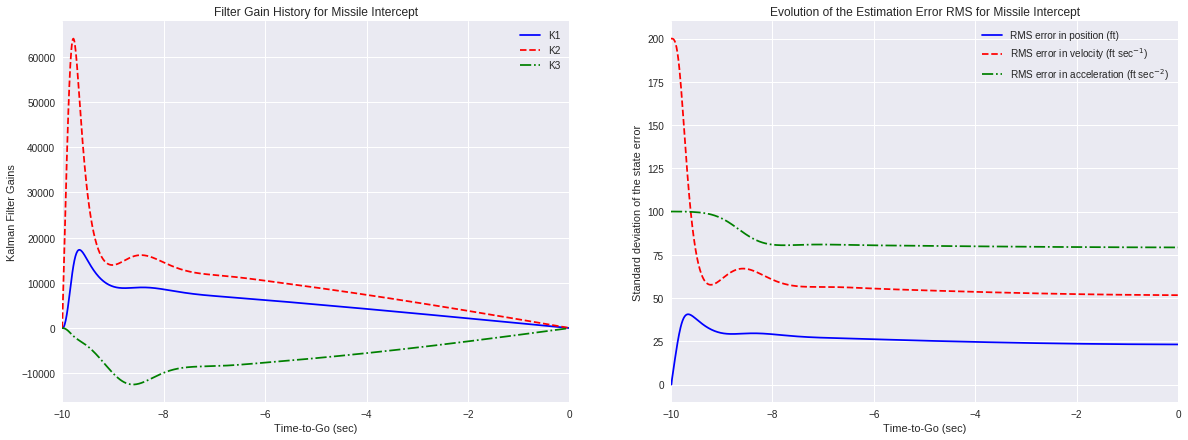

In [0]:
# Plots of filter gain history
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(tvec, K1, '-', color = "blue")
ax[0].plot(tvec, K2, '--', color = "red")
ax[0].plot(tvec, K3, '-.', color = "green")
ax[0].set_title('Filter Gain History for Missile Intercept')
ax[0].set_xlabel('Time-to-Go (sec)')
ax[0].set_ylabel('Kalman Filter Gains')
ax[0].legend(['K1', 'K2', 'K3'], loc='upper right')
ax[0].set_xlim(-tf,t0)

# Plots of estimation error
ax[1].plot(tvec, np.sqrt(P[:,0,0]), '-', color = "blue")
ax[1].plot(tvec, np.sqrt(P[:,1,1]), '--', color = "red")
ax[1].plot(tvec, np.sqrt(P[:,2,2]), '-.', color = "green")
ax[1].set_title('Evolution of the Estimation Error RMS for Missile Intercept')
ax[1].set_xlabel('Time-to-Go (sec)')
ax[1].set_ylabel('Standard deviation of the state error')
ax[1].legend(['RMS error in position (ft)', 'RMS error in velocity\
 (ft sec$^{-1}$)', 'RMS error in acceleration (ft sec$^{-2}$)'])
ax[1].set_xlim(-tf,t0)
plt.show()

## Plots of Actual/Estimated States

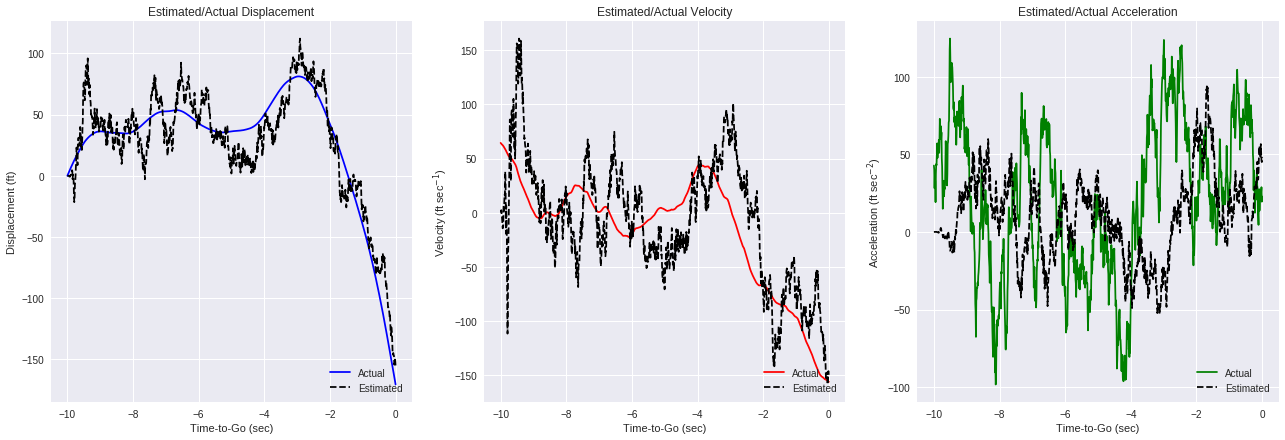

In [0]:
# Plots of state trajectories
fig, ax = plt.subplots(1,3, figsize = (22,7))
ax[0].plot(tvec, y, '-', color = "blue")
ax[1].plot(tvec, v, '-', color = "red")
ax[2].plot(tvec, aT, '-', color = "green")

# Plots of estimated states
ax[0].plot(tvec, yh, '--', color = "black")
ax[1].plot(tvec, vh, '--', color = "black")
ax[2].plot(tvec, aTh, '--', color = "black")

ax[0].set_title('Estimated/Actual Displacement')
ax[0].set_xlabel('Time-to-Go (sec)')
ax[0].set_ylabel('Displacement (ft)')
ax[0].legend(['Actual', 'Estimated'], loc='lower right')

ax[1].set_title('Estimated/Actual Velocity')
ax[1].set_xlabel('Time-to-Go (sec)')
ax[1].set_ylabel('Velocity (ft sec$^{-1}$)')
ax[1].legend(['Actual', 'Estimated'], loc='lower right')

ax[2].set_title('Estimated/Actual Acceleration')
ax[2].set_xlabel('Time-to-Go (sec)')
ax[2].set_ylabel('Acceleration (ft sec$^{-2}$)')
ax[2].legend(['Actual', 'Estimated'], loc='lower right')

Text(0, 0.5, 'Velocity (ft sec$^{-1}$)')

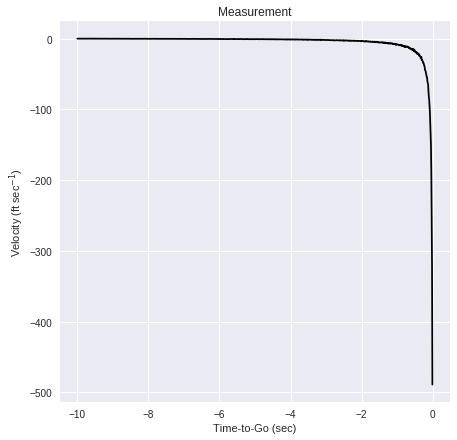

In [0]:
# Plot of the measurement

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(tvec[:-1], z[:-1], '-', color = "black")
ax.set_title('Measurement')
ax.set_xlabel('Time-to-Go (sec)')
ax.set_ylabel('Velocity (ft sec$^{-1}$)')

## Monte Carlo Simulation of the Error RMS

In [0]:
# The dynamic simulation is run n times and the error RMS values are
# averaged over the runs.
runs = 5000 # Number of simulations
ErrVar = 0 # Initialize error variance counter
for i in range(runs):
  # Run the dynamic simulation
  _,_,_,_,_,_,Xvar,_ = f_DynamicSim(t0,tf,tau,dt,length,Vc,R1,R2,ap,Ev,Ev2,Ea,\
                                    Ea2,En,F,B,G,W,Hb2,P0,L)
  ErrVar += Xvar # Increment error variance counter
ErrVar /= runs # Divide error variance counter by number of runs
ErrRMS = np.sqrt(ErrVar) # Error RMS

y_RMS = ErrRMS[:,0,0]  # y RMS
v_RMS = ErrRMS[:,1,0]  # v RMS
aT_RMS = ErrRMS[:,2,0] # aT RMS

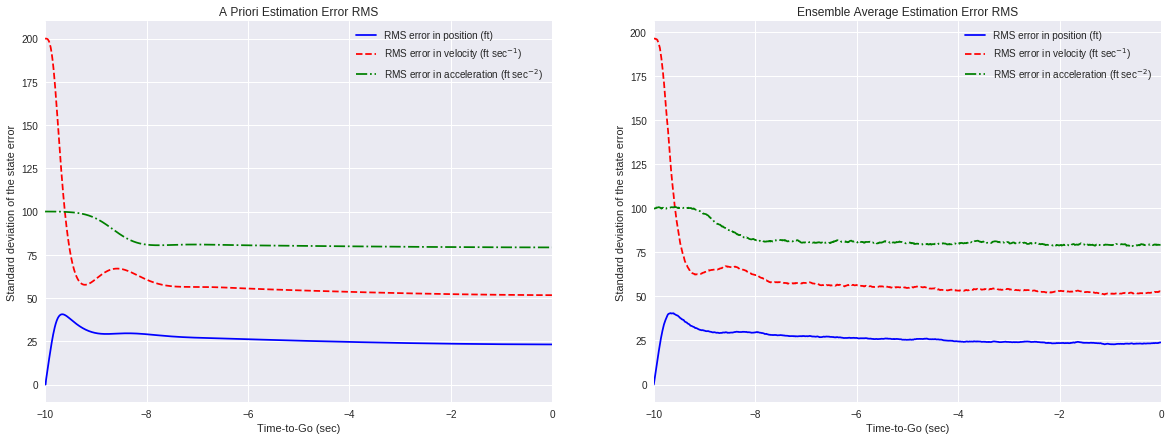

In [0]:
# Plotting the ensemble averages of the error RMS values
fig, ax = plt.subplots(1,2, figsize=(20,7))

# Plots of a priori estimation errors
ax[0].plot(tvec, np.sqrt(P[:,0,0]), '-', color = "blue")
ax[0].plot(tvec, np.sqrt(P[:,1,1]), '--', color = "red")
ax[0].plot(tvec, np.sqrt(P[:,2,2]), '-.', color = "green")
ax[0].set_title('A Priori Estimation Error RMS')
ax[0].set_xlabel('Time-to-Go (sec)')
ax[0].set_ylabel('Standard deviation of the state error')
ax[0].legend(['RMS error in position (ft)', 'RMS error in velocity\
 (ft sec$^{-1}$)', 'RMS error in acceleration (ft sec$^{-2}$)'])
ax[0].set_xlim(-tf,t0)

# Plots of ensemble average estimation errors
ax[1].plot(tvec[:-1], y_RMS[:-1], '-', color = "blue")
ax[1].plot(tvec[:-1], v_RMS[:-1], '--', color = "red")
ax[1].plot(tvec[:-1], aT_RMS[:-1], '-.', color = "green")
ax[1].set_title('Ensemble Average Estimation Error RMS')
ax[1].set_xlabel('Time-to-Go (sec)')
ax[1].set_ylabel('Standard deviation of the state error')
ax[1].legend(['RMS error in position (ft)', 'RMS error in velocity\
 (ft sec$^{-1}$)', 'RMS error in acceleration (ft sec$^{-2}$)'])
ax[1].set_xlim(-tf,t0)
plt.show()

In [0]:
# Percent errors of estimation errors
# np.disp(np.max((np.sqrt(P[:,0,0])-y_RMS)/np.sqrt(P[:,0,0])))
# np.disp(np.max((np.sqrt(P[:,1,1])-v_RMS)/np.sqrt(P[:,1,1])))
# np.disp(np.max((np.sqrt(P[:,2,2])-aT_RMS)/np.sqrt(P[:,2,2])))


## Showing that the Residual Process is Uncorrelated in Time

In [0]:
# The dynamic simulation is run n times and the residuals are
# averaged over the runs.
runs = 1 # Number of simulations
rc = 0 # Initialize residual counter
for i in range(runs):
  # Run the dynamic simulation
  _,_,_,_,_,_,_,r = f_DynamicSim(t0,tf,tau,dt,length,Vc,R1,R2,ap,Ev,Ev2,Ea,\
                                   Ea2,En,F,B,G,W,Hb2,P0,L)
  rc += r # Increment residual counter
rc /= runs # Divide residual counter by number of runs

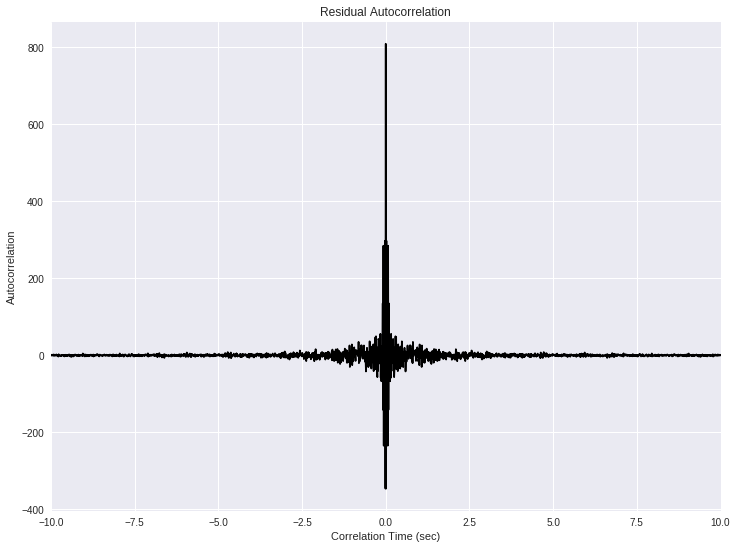

In [0]:
# Computing and plotting the autocorrelation of the residual process
auto_corr = np.correlate(rc[:-1],rc[:-1],mode='full') # Compute autocorrelation
corr_tvec = np.linspace(-tf,tf,len(auto_corr)) # Time vector

fig, ax = plt.subplots(1,1,figsize=(12,9))
ax.plot(corr_tvec, auto_corr, color = "black")
ax.set_title('Residual Autocorrelation')
ax.set_xlabel('Correlation Time (sec)')
ax.set_ylabel('Autocorrelation')
ax.set_xlim(-tf,tf)
plt.show()

## Random Telegraph Signal Model

In [0]:
# Run the dynamic simulation with random telegraph signal.
_,_,_,_,X_rt,Xh_rt,_,_ = f_DynamicSim(t0,tf,tau,dt,length,Vc,R1,R2,ap,Ev,Ev2,\
                                      Ea,Ea2,En,F,B,G,W,Hb2,P0,L,mode=1)

y_rt = X_rt[:,0,0]  # Missile displacement
v_rt = X_rt[:,1,0]  # Missile velocity
aT_rt = X_rt[:,2,0] # Target acceleration

yh_rt = Xh_rt[:,0,0]  # Estimated missile displacement
vh_rt = Xh_rt[:,1,0]  # Estimated missile velocity
aTh_rt = Xh_rt[:,2,0] # Estimated target acceleration

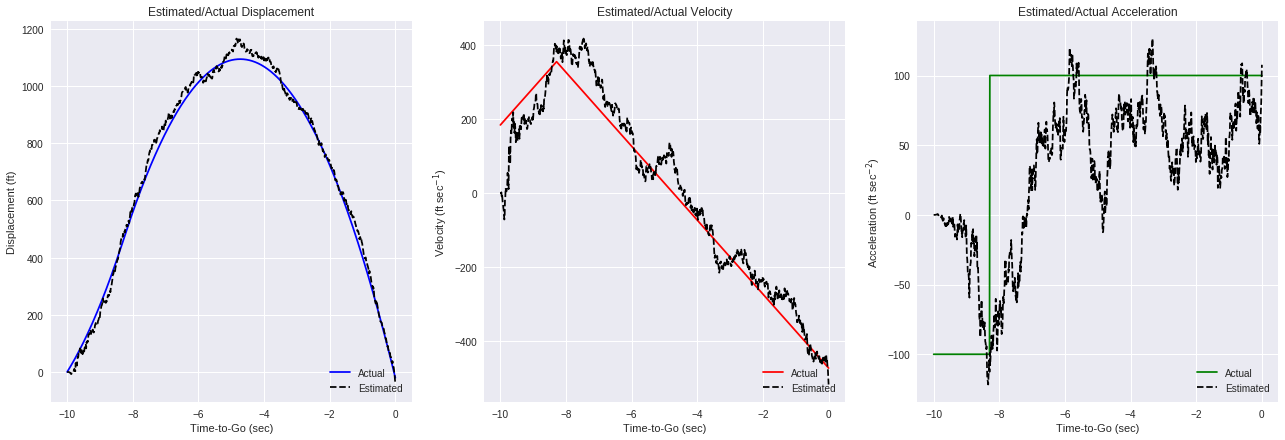

In [0]:
# Plotting the state trajectories using the random telegraph signal

# Plots of state trajectories
fig, ax = plt.subplots(1,3, figsize = (22,7))
ax[0].plot(tvec, y_rt, '-', color = "blue")
ax[1].plot(tvec, v_rt, '-', color = "red")
ax[2].plot(tvec, aT_rt, '-', color = "green")

# Plots of estimated states
ax[0].plot(tvec, yh_rt, '--', color = "black")
ax[1].plot(tvec, vh_rt, '--', color = "black")
ax[2].plot(tvec, aTh_rt, '--', color = "black")

ax[0].set_title('Estimated/Actual Displacement')
ax[0].set_xlabel('Time-to-Go (sec)')
ax[0].set_ylabel('Displacement (ft)')
ax[0].legend(['Actual', 'Estimated'], loc='lower right')

ax[1].set_title('Estimated/Actual Velocity')
ax[1].set_xlabel('Time-to-Go (sec)')
ax[1].set_ylabel('Velocity (ft sec$^{-1}$)')
ax[1].legend(['Actual', 'Estimated'], loc='lower right')

ax[2].set_title('Estimated/Actual Acceleration')
ax[2].set_xlabel('Time-to-Go (sec)')
ax[2].set_ylabel('Acceleration (ft sec$^{-2}$)')
ax[2].legend(['Actual', 'Estimated'], loc='lower right')

In [0]:
# The Monte Carlo simulation is rerun with mode=1, so that the random
# telegraph model is used in the dynamic simulation.

# The dynamic simulation is run n times and the error RMS values are
# averaged over the runs.
runs = 5000 # Number of simulations
ErrVar_rt = 0 # Initialize error variance counter
for i in range(runs):
  # Run the dynamic simulation
  _,_,_,_,X_rt,Xh_rt,Xvar_rt,_ = f_DynamicSim(t0,tf,tau,dt,length,Vc,R1,R2,\
                                              ap,Ev,Ev2,Ea,Ea2,En,F,B,G,W,\
                                              Hb2,P0,L,mode=1)
  ErrVar_rt += Xvar_rt # Increment error variance counter
ErrVar_rt /= runs # Divide error variance counter by number of runs
ErrRMS_rt = np.sqrt(ErrVar_rt) # Error RMS

y_RMS_rt = ErrRMS_rt[:,0,0]  # y RMS
v_RMS_rt = ErrRMS_rt[:,1,0]  # v RMS
aT_RMS_rt = ErrRMS_rt[:,2,0] # aT RMS

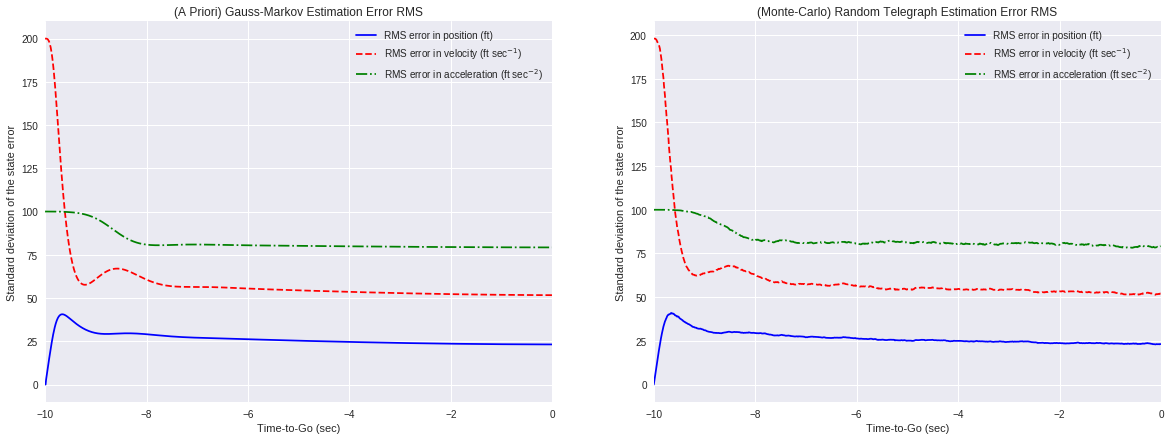

In [0]:
# The Gauss-Markov and Random Telegraph estimation errors are plotted
# side by side.

# Plotting the ensemble averages of the error RMS values
fig, ax = plt.subplots(1,2, figsize=(20,7))

# Plots of (a priori) Gauss-Markov estimation error RMS values
ax[0].plot(tvec, np.sqrt(P[:,0,0]), '-', color = "blue")
ax[0].plot(tvec, np.sqrt(P[:,1,1]), '--', color = "red")
ax[0].plot(tvec, np.sqrt(P[:,2,2]), '-.', color = "green")
ax[0].set_title('(A Priori) Gauss-Markov Estimation Error RMS')
ax[0].set_xlabel('Time-to-Go (sec)')
ax[0].set_ylabel('Standard deviation of the state error')
ax[0].legend(['RMS error in position (ft)', 'RMS error in velocity\
 (ft sec$^{-1}$)', 'RMS error in acceleration (ft sec$^{-2}$)'])
ax[0].set_xlim(-tf,t0)

# Plots of the (ensemble average) Random Telegraph estimation error RMS values
ax[1].plot(tvec[:-1], y_RMS_rt[:-1], '-', color = "blue")
ax[1].plot(tvec[:-1], v_RMS_rt[:-1], '--', color = "red")
ax[1].plot(tvec[:-1], aT_RMS_rt[:-1], '-.', color = "green")
ax[1].set_title('(Monte-Carlo) Random Telegraph Estimation Error RMS')
ax[1].set_xlabel('Time-to-Go (sec)')
ax[1].set_ylabel('Standard deviation of the state error')
ax[1].legend(['RMS error in position (ft)', 'RMS error in velocity\
 (ft sec$^{-1}$)', 'RMS error in acceleration (ft sec$^{-2}$)'])
ax[1].set_xlim(-tf,t0)
plt.show()